# Step A - Multiple Product Detection

-Freddy Fernandes
freddy.fernandes@studio.unibo.it
Erasmus Exchange Student

In [61]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
sift = cv2.SIFT_create()

In [62]:
def FeatureMatch(Model_Descriptors, Scene_Descriptors, Treshold = 0.45, k=2):
    # Initialize FLANN-based matcher parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    # Create FLANN-based matcher and perform k-nearest neighbor matching
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(Model_Descriptors, Scene_Descriptors, k)

    # Filter out good matches using the ratio test
    good = []
    for m, n in matches:
        if m.distance < Treshold * n.distance:
            good.append(m)
    return good

In [63]:
def findmodel(x, check):
    if x == 0:
        return 0, "Nesquik"
    elif x == 1:
        return 1, "CK blue"
    elif x == 11:
        return 11, "CK orange"
    elif x == 19:
        return 19, "Country crisp"
    elif x == 24:
        return 24, "Fitness"
    elif x == 25:
        return 25, "CocoPops"
    elif x == 26:
        return 26, "Nesquik Duo"

def Output(detections, s):
    # Print detection results for each model in the given scene
    for x in models:
        model_number, model_label = findmodel(x, check=False)  # Get the label for the model
        print('Product {} (Model {}) - {} instance/s found:'.format(model_label, model_number, detections[s][x]['count'])) 
        if detections[s][x].get('width', None) is not None:
            # Directly access width and height, assuming they are single values
            width = detections[s][x]['width']
            height = detections[s][x]['height']
            pos = detections[s][x]['pos']
            print('\tInstance position: {}, width: {}px, height: {}px'.format(pos, width, height))
    print('_' * 50 + '\n')

In [64]:
def display_model_images(model_features):
    n = len(model_features)
    fig = plt.figure(figsize=(15, 10))
    for x, (model_id, features) in enumerate(model_features.items()):
        img = features[0]
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Get the model label using findmodel function
        _, model_label = findmodel(model_id, check=False)
        fig.add_subplot(2, (n + 1) // 2, x + 1)
        plt.title("Model {}: {}".format(model_id, model_label))  # Display both model number and label
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

In [65]:
def Eucdist(A, B):
    # Calculate and return the Euclidean distance between two points A and B
    return math.sqrt( np.power(A[0] - B[0], 2) +  np.power(A[1] - B[1], 2))

In [66]:
def draw_bbox(img, bbox, scene_image, s):
    # Draw bounding boxes on the image
    if img is None:
        img = np.copy(scene_image[s][IMAGE_INDEX])
    for top_L, bot_R in bbox:
        bbox_op = cv2.rectangle(img, top_L, bot_R, (0,255,0), 10)
    
    # Return the image with bounding boxes if any exist, else return None
    if(len(bbox) > 0):
        return bbox_op
    else:
        return None

In [67]:
def adjust_bbox(bbox, scene_image):
    # Adjust bounding box coordinates to fit within the scene image boundaries
    adjusted_bbox = []
    scene_height = scene_image[s][IMAGE_INDEX].shape[0]
    scene_width = scene_image[s][IMAGE_INDEX].shape[1]

    for [top_left, bottom_right] in bbox:
        top_left = (max(min(int(top_left[0]), scene_width), 0), 
                    max(min(int(top_left[1]), scene_height), 0))
        bottom_right = (max(min(int(bottom_right[0]), scene_width), 0), 
                        max(min(int(bottom_right[1]), scene_height), 0))
        adjusted_bbox.append([top_left, bottom_right])
    return adjusted_bbox

def black_plot(img, bbox, scene_image, s):
    # Draw black rectangles (filled) on the image for each bounding box
    for top_L, bot_R in bbox:
        bbox_op = cv2.rectangle(img, top_L, bot_R, (0,0,0), -1)

    # Return the image with black plots if any exist, else return None
    if(len(bbox) > 0):
        return bbox_op
    else:
        return None

In [68]:
# Function to divide an image into bins and calculate the mean color in each bin
def bins(image, bins_w=3, bins_h=4):
    bins = {}
    img_width, img_height = image.shape[1], image.shape[0]
    step_width, step_height = img_width // bins_w, img_height // bins_h

    for r in range(bins_h):
        for c in range(bins_w):
            # Calculate the coordinates for each bin
            start_row, end_row = r * step_height, min((r + 1) * step_height, img_height)
            start_col, end_col = c * step_width, min((c + 1) * step_width, img_width)

            # Extract and compute the mean color of each bin
            bin_img = image[start_row:end_row, start_col:end_col]
            mean_colors = tuple(np.mean(bin_img[:, :, m]) for m in range(3))  # For each channel: B, G, R
            bins[r, c] = mean_colors
    return bins

In [69]:
# Function bounding boxes based on color binning and thresholding
def color_bins(adjusted_bbox, 
               scene_image, m, s, N=3, M=4, 
               threshold=78, bad_threshold=1):

    main_bbox = []
    bins_mod = bins(model_features[m][IMAGE_INDEX], N, M)

    # Check each bounding box in the adjusted list
    for [top_left, bottom_right] in adjusted_bbox:
        scene_bins = bins(scene_image[s][IMAGE_INDEX][top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]], N, M)

    # Count bins that differ significantly from the model image
        bad = sum(
            1 for k, v in bins_mod.items() 
            if any(np.absolute(v[m] - scene_bins[k][m]) >= threshold for m in range(3))
        )

    # If the number of significantly different bins is below the threshold, include the bounding box
        if bad < bad_threshold:
            main_bbox.append([
                (int(top_left[0]), int(top_left[1])),
                (int(bottom_right[0]), int(bottom_right[1]))
            ])
    return main_bbox

In [70]:
# Constants for indexing in the feature arrays
IMAGE_INDEX      = 0
KEYPOINT_INDEX   = 1
DESCRIPTOR_INDEX = 2

# Lists of models and scenes to process
models = [0, 1 , 11, 19, 24, 26, 25] 
scenes = [1,2,3,4,5]
MIN_NUM_OF_MATCHES = 18

# Dictionaries to store various features and detection results
scene_bbox = {}
sm_feat = {}
detections = {}    
scene_features = {}
model_features = {}
model_means = {}

# Read and store features for each model image
for m in models:
    model_img = cv2.imread('./models/{}.jpg'.format(m), cv2.COLOR_BGR2RGB)
    mod_keypoint = sift.detect(model_img)
    mod_keypoint, mod_des = sift.compute(model_img, mod_keypoint)
    model_features[m] = [model_img, mod_keypoint, mod_des]
    b,g,r = cv2.split(model_features[m][IMAGE_INDEX])
    model_means[m] = [np.mean(r), np.mean(g), np.mean(b)]
    
# Read and store features for each scene image
for m in scenes:
    scene_img = cv2.imread('./scenes/e{}.png'.format(m), cv2.COLOR_BGR2RGB)
    scene_keypoint = sift.detect(scene_img)
    scene_keypoint, scene_desc = sift.compute(scene_img, scene_keypoint)
    scene_features[m] = [scene_img, scene_keypoint, scene_desc]

In [71]:
# Process each scene and model pair to detect objects
for s in scenes:
    scene_bbox[s] = np.copy(scene_features[s][IMAGE_INDEX])
    detections[s] = {}
    for m in models:
        image1 = np.copy(scene_features[s][IMAGE_INDEX])
        detections[s][m] = {}
        detections[s][m]['count'] = 0
        
        finding = True
        
        while finding:
            # Detect keypoints and compute descriptors in the current scene image
            scene_keypoint = sift.detect(image1)
            scene_keypoint, scene_desc = sift.compute(image1, scene_keypoint)
            sm_feat[s] = [image1, scene_keypoint, scene_desc] 
            
            # Match features between the model and the scene
            matches = FeatureMatch(model_features[m][DESCRIPTOR_INDEX], sm_feat[s][DESCRIPTOR_INDEX])
            
            if len(matches) < MIN_NUM_OF_MATCHES:
                finding = False

             # If sufficient matches are found, calculate homography and bounding box
            if len(matches) >= MIN_NUM_OF_MATCHES:
                
                src_pts = np.float32([ model_features[m][KEYPOINT_INDEX][match.queryIdx].pt for match in matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ sm_feat[s][KEYPOINT_INDEX][match.trainIdx].pt for match in matches ]).reshape(-1,1,2)
                # Compute homography
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                matchesMask = mask.ravel().tolist()
                
                # Compute the transformed corners of the model image
                h,w = model_features[m][IMAGE_INDEX].shape[:2]
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) 
                dst = cv2.perspectiveTransform(pts,M) 
                # Calculate bounding box dimensions
                tl_bbox, bl_bbox, tr_bbox, br_bbox= dst[0][0], dst[1][0], dst[3][0], dst[2][0]
                width_bbox,height_bbox  = int(Eucdist(tl_bbox, tr_bbox)), int(Eucdist(tl_bbox, bl_bbox))

                # Process and draw bounding box (if ceral box shape)
                if width_bbox < height_bbox:
                    bbox = [[tl_bbox, br_bbox]]
                    adjusted_bbox = adjust_bbox(bbox, scene_features)
                    main_bbox = color_bins(adjusted_bbox, scene_features, m, s)

                    # Check if main bounding box is found and update detection values
                    if len(main_bbox) > 0:
                        finding = False
                        for [top_left, bottom_right] in main_bbox:
                            detections[s][m]['count'] += 1
                            detections[s][m]['width'] = width_bbox
                            detections[s][m]['height'] = height_bbox
                            center_x = int((top_left[0] + bottom_right[0]) / 2)
                            center_y = int((top_left[1] + bottom_right[1]) / 2)
                            detections[s][m]['pos'] = (center_x, center_y)
                    else:
                        # Black out the processed area if no main bounding box is found
                        for [top_left, bottom_right] in adjusted_bbox:
                            image1 = black_plot(image1, adjusted_bbox, scene_features, s)
                    # Draw the bounding box on the original scene image
                    img_bb = draw_bbox(scene_bbox[s], main_bbox,scene_features, s)
                    
                    if img_bb is not None:
                        scene_bbox[s] = img_bb
            else:
                matchesMask = None
             # Draw matches between the model and the scene for visualization
            draw_params = dict(matchColor = (0,255,0), 
                               singlePointColor = None,
                               matchesMask = matchesMask,
                               flags = 2) 
            img3 = cv2.drawMatches(model_features[m][IMAGE_INDEX], 
                                   model_features[m][KEYPOINT_INDEX], 
                                   scene_features[s][IMAGE_INDEX], 
                                   scene_features[s][KEYPOINT_INDEX],
                                   matches, 
                                   None,  
                                   **draw_params)

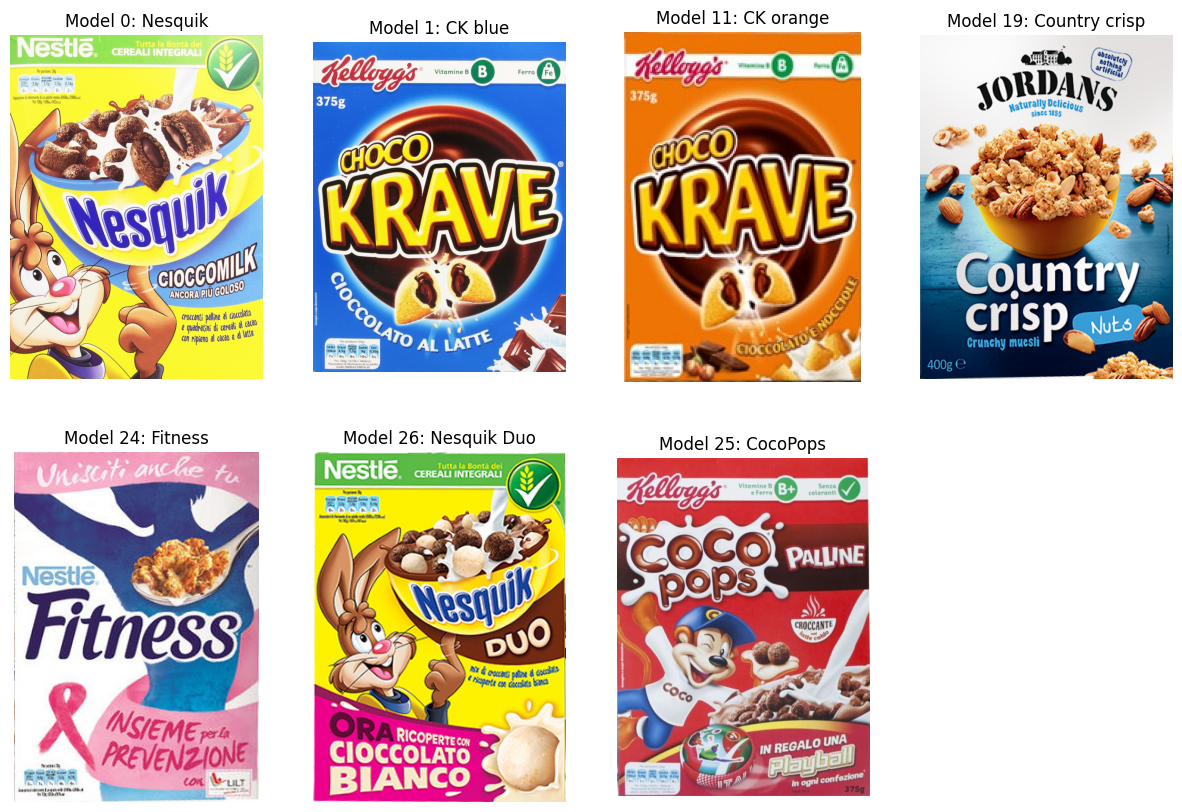

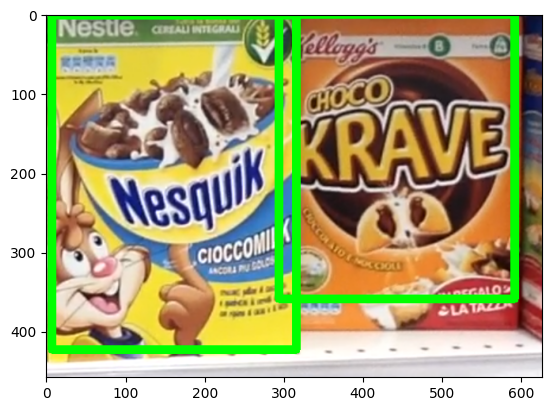

Product Nesquik (Model 0) - 1 instance/s found:
	Instance position: (161, 212), width: 311px, height: 437px
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 1 instance/s found:
	Instance position: (443, 179), width: 299px, height: 391px
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 0 instance/s found:
Product Nesquik Duo (Model 26) - 0 instance/s found:
Product CocoPops (Model 25) - 0 instance/s found:
__________________________________________________



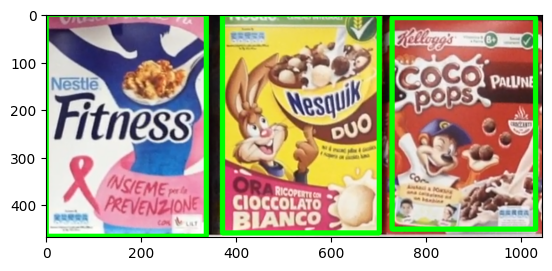

Product Nesquik (Model 0) - 0 instance/s found:
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 0 instance/s found:
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 1 instance/s found:
	Instance position: (168, 233), width: 334px, height: 490px
Product Nesquik Duo (Model 26) - 1 instance/s found:
	Instance position: (536, 229), width: 337px, height: 490px
Product CocoPops (Model 25) - 1 instance/s found:
	Instance position: (879, 229), width: 309px, height: 446px
__________________________________________________



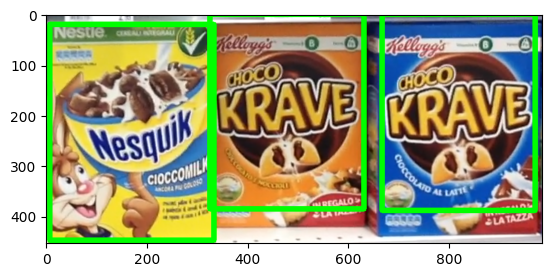

Product Nesquik (Model 0) - 1 instance/s found:
	Instance position: (170, 233), width: 325px, height: 444px
Product CK blue (Model 1) - 1 instance/s found:
	Instance position: (819, 194), width: 301px, height: 412px
Product CK orange (Model 11) - 1 instance/s found:
	Instance position: (478, 192), width: 295px, height: 400px
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 0 instance/s found:
Product Nesquik Duo (Model 26) - 0 instance/s found:
Product CocoPops (Model 25) - 0 instance/s found:
__________________________________________________



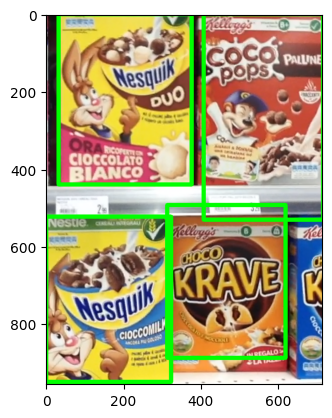

Product Nesquik (Model 0) - 1 instance/s found:
	Instance position: (161, 736), width: 325px, height: 444px
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 1 instance/s found:
	Instance position: (464, 690), width: 299px, height: 399px
Product Country crisp (Model 19) - 0 instance/s found:
Product Fitness (Model 24) - 0 instance/s found:
Product Nesquik Duo (Model 26) - 1 instance/s found:
	Instance position: (203, 220), width: 344px, height: 497px
Product CocoPops (Model 25) - 1 instance/s found:
	Instance position: (560, 265), width: 300px, height: 579px
__________________________________________________



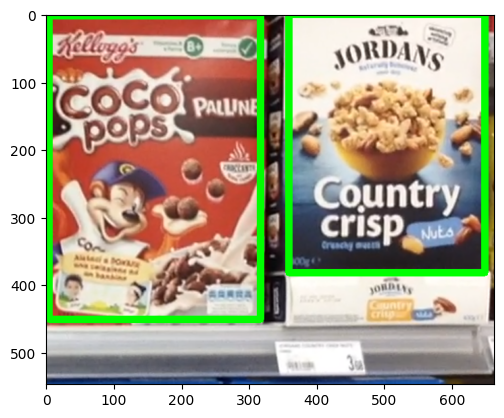

Product Nesquik (Model 0) - 0 instance/s found:
Product CK blue (Model 1) - 0 instance/s found:
Product CK orange (Model 11) - 0 instance/s found:
Product Country crisp (Model 19) - 1 instance/s found:
	Instance position: (504, 191), width: 293px, height: 387px
Product Fitness (Model 24) - 0 instance/s found:
Product Nesquik Duo (Model 26) - 0 instance/s found:
Product CocoPops (Model 25) - 1 instance/s found:
	Instance position: (160, 226), width: 319px, height: 445px
__________________________________________________



In [72]:
display_model_images(model_features)
# Display the scene images with drawn bounding boxes and output the detection results
for s in scenes:
    plt.imshow(cv2.cvtColor(scene_bbox[s], cv2.COLOR_BGR2RGB))
    plt.show()
    Output(detections, s)